## Models

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the training set
Trainset = pd.read_csv('Kickstarter_Train.csv')
Seed = 42

### Preprocessing of the data

Before we can start modelling we need to chose the features which will be used. Secondly we need to hot encode out 'category' variable.

In [3]:
# There are only a few useful parameters we can pass to our prediction algorithms
Trainset = Trainset[['blurb_length', 'category', 'converted_goal_amount',
                     'name_length', 'days_total', 'days_until_launch', 'state']]

In [4]:
# Hot-one-encoding of the category parameter
category_dummies = pd.get_dummies(Trainset['category'], drop_first=True)

# Put them together and drop the original category column
Trainset = pd.concat([Trainset, category_dummies], axis=1)
Trainset.drop('category', axis=1, inplace=True)

***
There is a lot of data, so another split into train and test can be performed.
***

In [5]:
# Split the set into X and y
from sklearn.model_selection import train_test_split
X = Trainset.drop('state', axis=1)
y = Trainset.state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

***
For scaling we use the RobustScaler as it is more sensitive towards outliers, which are present in the data.
***

In [6]:
# Import RobustScaler
from sklearn.preprocessing import RobustScaler

# Apply Scaling
features = ['blurb_length', 'converted_goal_amount', 'name_length', 'days_total', 'days_until_launch']
transformer = RobustScaler().fit(X[features]) # Fit the scaler on the complete Trainset. Later one we need to do the same with the validation set.
X[features] = transformer.transform(X[features])

***
Next up we import everything we need for the whole modelling process.
***

In [7]:
# Import models and other needed modules
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score

***
The focus is on recall, so a scorer is needed for later use in cross-validation
***

In [8]:
# Define scorer
#scorer = make_scorer(recall_score)

***
For evaluation we are going to use a few different parameters:    
<ul>
<li>Confusion matrix</li>
<li>Classifciation report, which inclued recall, precision, f1-score etc.</li>
<li>The singular recall score</li>
<li>The Precision-Recall curve and the auc (area under curve)</li>
</ul>

***

In [9]:
# Empty df for the metrics we want to compare in the end
df_metrics = pd.DataFrame({'model' : ['Dummy', 'KNN', 'DT', 'LR', 'RF'], 'recall' : [1,2,3,4,5], 'auc' : [1,2,3,4,5]})
df_metrics.set_index('model', inplace=True)

# Print out all evaluation metrics we want
def evaluation_metrics (y, y_pred, y_proba, model='default'):
    pos_probs = y_proba[:, 1]
    precision, recall, _ = precision_recall_curve(y, pos_probs)
    recall_real = recall_score(y, y_pred).round(2)
    auc_real = auc(recall, precision).round(2)
    if model != 'default':
        df_metrics.loc[model, 'recall'], df_metrics.loc[model, 'auc'] = recall_real, auc_real
    print('---------------------------------------------------------')
    print('Confusion Matrix:')
    print(confusion_matrix(y, y_pred))
    print('---------------------------------------------------------')
    print(classification_report(y, y_pred))
    print('---------------------------------------------------------')
    print(f'Recall score: {recall_score(y, y_pred).round(2)}')
    print('---------------------------------------------------------')
    print(f'PR-AUC score: {auc(recall, precision).round(2)}')
    print('---------------------------------------------------------')

In [10]:
# Best parameters from Grid-RandomizedSearch

def best_parameters(model_name):
    print('---------------')
    print('Best parameters')
    print('---------------')
    for pair in model_name.best_params_.items():
        print(f'{pair[0].capitalize()} : {pair[1]}')

## Baseline

The dummy classifier can be used in multiple ways. One of the most common would be to simply let the classifier predict everything accoding to the most frequent class, which means it would in this case only predict positives, since 58% of all outcomes are positive. This would lead to a recall score of 1, as there are no false negatives.
This is not what we want as baseline, since our goal is to achieve a high recall with a good area under curve score. The baseline would not offer good comparables.
Therefore we chose to use another approach and let the classifier chose the outcome somewhat randomly, while still keeping the imbalance of the two classes in mind.
This actually gives us a baseline which we can improve upon.

In [11]:
# Define model
dummy_clf = DummyClassifier(strategy="stratified", random_state=Seed) # 'stratified' generates predictions by respecting the training set’s class distribution.

# Fit on the data
dummy_clf.fit(X_train, y_train)

# Predict the target value
y_pred_dummy = dummy_clf.predict(X_train)

# Calculate probability and precision/recall-auc-score
y_proba_dummy = dummy_clf.predict_proba(X_train)

evaluation_metrics(y_train, y_pred_dummy, y_proba_dummy, 'Dummy')

---------------------------------------------------------
Confusion Matrix:
[[19570 27576]
 [27580 38494]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.42      0.42     47146
           1       0.58      0.58      0.58     66074

    accuracy                           0.51    113220
   macro avg       0.50      0.50      0.50    113220
weighted avg       0.51      0.51      0.51    113220

---------------------------------------------------------
Recall score: 0.58
---------------------------------------------------------
PR-AUC score: 0.7
---------------------------------------------------------


***
Our baseline scores are 0.58 for Recall and 0.7 for AUC.
***

## KNN
### Trainset

In [12]:
# Define model and parameters for RandomizedSearchCV
knn = KNeighborsClassifier()
param_dist_knn = {'n_neighbors' : np.linspace(5, 100, num = 20, dtype='int64').tolist(),
                  'metric' : ['manhattan', 'euclidean']
                 }

# RandomizedSearchCV
knn_search = RandomizedSearchCV(knn, param_dist_knn, verbose=1, n_jobs=-1, random_state=Seed, cv=5)
knn_search.fit(X_train, y_train)

# Print bester parameters
best_parameters(knn_search)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


---------------
Best parameters
---------------
N_neighbors : 35
Metric : manhattan


In [13]:
# Use the best parameters 
knn_best = knn_search.best_estimator_

# Fit on the traindata
knn_best.fit(X_train, y_train)

# Predict the target value
y_pred_knn = knn_best.predict(X_train)

y_proba_knn = knn_best.predict_proba(X_train)

evaluation_metrics (y_train, y_pred_knn, y_proba_knn)

---------------------------------------------------------
Confusion Matrix:
[[23065 24081]
 [10096 55978]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.49      0.57     47146
           1       0.70      0.85      0.77     66074

    accuracy                           0.70    113220
   macro avg       0.70      0.67      0.67    113220
weighted avg       0.70      0.70      0.69    113220

---------------------------------------------------------
Recall score: 0.85
---------------------------------------------------------
PR-AUC score: 0.78
---------------------------------------------------------


***
A Recall score of 0.85, while maintaining a AUC of 0.78 looks promising. Remember though, that this is done only with the trainingset.
***

### Testset

In [14]:
# Predict the Testset
y_pred_knn_test = knn_best.predict(X_test)

y_proba_knn_test = knn_best.predict_proba(X_test)

evaluation_metrics (y_test, y_pred_knn_test, y_proba_knn_test)

---------------------------------------------------------
Confusion Matrix:
[[ 7307  8408]
 [ 3691 18334]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.46      0.55     15715
           1       0.69      0.83      0.75     22025

    accuracy                           0.68     37740
   macro avg       0.67      0.65      0.65     37740
weighted avg       0.68      0.68      0.67     37740

---------------------------------------------------------
Recall score: 0.83
---------------------------------------------------------
PR-AUC score: 0.74
---------------------------------------------------------


***
Recall is still good. The AUC gets close to the baseline of 0.7 though.
We have to look at the validation set later to see how it holds up.
***

## Decision Tree Classifier
### Trainset

In [15]:
# Define model and parameters for GridSearch
tree = DecisionTreeClassifier(random_state=Seed, class_weight='balanced')
param_dist_tree = {'criterion' : ['gini', 'entropy'],
                   'splitter' : ['best', 'random'],
                   'max_depth' : np.linspace(5, 100, num = 20, dtype='int64').tolist(),
                   'max_features' : ['sqrt', 'log2', None],
                   'min_samples_split' : np.linspace(5, 20, num = 5, dtype='int64').tolist(),
                   'max_leaf_nodes' : np.linspace(1, 100, num = 50, dtype='int64').tolist() + [None]
                  }

# Run GridSearch
tree_search = RandomizedSearchCV(tree, param_dist_tree, cv=5, n_jobs=-1, verbose=1, n_iter=100)
tree_search.fit(X_train, y_train)

# Print best parameters
best_parameters(tree_search)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.9s finished


---------------
Best parameters
---------------
Splitter : best
Min_samples_split : 16
Max_leaf_nodes : 89
Max_features : None
Max_depth : 90
Criterion : gini


In [16]:
# Use the best parameters on the model
tree_best = tree_search.best_estimator_

# Fit on the data
tree_best.fit(X_train, y_train)

# Predict the target value
y_pred_tree = tree_best.predict(X_train)
y_proba_tree = tree_best.predict_proba(X_train)

evaluation_metrics(y_train, y_pred_tree, y_proba_tree)

---------------------------------------------------------
Confusion Matrix:
[[30231 16915]
 [17732 48342]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.64      0.64     47146
           1       0.74      0.73      0.74     66074

    accuracy                           0.69    113220
   macro avg       0.69      0.69      0.69    113220
weighted avg       0.69      0.69      0.69    113220

---------------------------------------------------------
Recall score: 0.73
---------------------------------------------------------
PR-AUC score: 0.78
---------------------------------------------------------


***
The Recall score on the trainset is 0.77, which is worse than KNN.  
The Curve score is better with 0.79.
***

### Testset

In [17]:
# Testset
y_pred_tree_test = tree_best.predict(X_test)
y_proba_tree_test = tree_best.predict_proba(X_test)

evaluation_metrics(y_test, y_pred_tree_test, y_proba_tree_test)

---------------------------------------------------------
Confusion Matrix:
[[10156  5559]
 [ 5949 16076]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     15715
           1       0.74      0.73      0.74     22025

    accuracy                           0.70     37740
   macro avg       0.69      0.69      0.69     37740
weighted avg       0.70      0.70      0.70     37740

---------------------------------------------------------
Recall score: 0.73
---------------------------------------------------------
PR-AUC score: 0.78
---------------------------------------------------------


***
Recall and Curve score of the testset are nearly identical to the trainset, which at least speaks for the models consistency.
***

## Logistic Regression
### Trainset

In [18]:
# Define model and parameters for GridSearch
lr = LogisticRegression(random_state=Seed, class_weight='balanced')
param_dist_lr = {'C' : [0.01, 0.025, 0.05, 0.1, 0.5, 1, 2]
                }

# Run GridSearch
lr_search = GridSearchCV(lr, param_dist_lr, cv=5, n_jobs=-1, verbose=1)
lr_search.fit(X_train, y_train)

# Print the best parameters
best_parameters(lr_search)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.2s finished


---------------
Best parameters
---------------
C : 0.05


In [19]:
# Use the best parameters on the model
lr_best = lr_search.best_estimator_

# Fit on the data
lr_best.fit(X_train, y_train)

# Predict the target value
y_pred_lr = lr_best.predict(X_train)
y_proba_lr = lr_best.predict_proba(X_train)

evaluation_metrics(y_train, y_pred_lr, y_proba_lr)

---------------------------------------------------------
Confusion Matrix:
[[29998 17148]
 [24087 41987]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.64      0.59     47146
           1       0.71      0.64      0.67     66074

    accuracy                           0.64    113220
   macro avg       0.63      0.64      0.63    113220
weighted avg       0.65      0.64      0.64    113220

---------------------------------------------------------
Recall score: 0.64
---------------------------------------------------------
PR-AUC score: 0.72
---------------------------------------------------------


***
Recall 0.64 and AUC 0.72.
Both are only slightly better than to chose the outcome at random.
***

### Testset

In [20]:
# Testset
y_pred_lr_test = lr_best.predict(X_test)
y_proba_lr_test = lr_best.predict_proba(X_test)

# Print evaluation metrics
evaluation_metrics(y_test, y_pred_lr_test, y_proba_lr_test)

---------------------------------------------------------
Confusion Matrix:
[[10052  5663]
 [ 7882 14143]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.64      0.60     15715
           1       0.71      0.64      0.68     22025

    accuracy                           0.64     37740
   macro avg       0.64      0.64      0.64     37740
weighted avg       0.65      0.64      0.64     37740

---------------------------------------------------------
Recall score: 0.64
---------------------------------------------------------
PR-AUC score: 0.73
---------------------------------------------------------


***
The scores stay pretty much the same. We'd have to do some further analysis to find out if we could improve upon that.
***

## Random Forest
### Trainset

In [21]:
# Define model and parameters for RandomizedSearchCV
rf = RandomForestClassifier(random_state=Seed, class_weight='balanced')
param_dist_rf = {'max_features' : ['sqrt', 'log2'],
                 'max_depth' : np.linspace(10, 110, num = 11).tolist() + [None],
                 'min_samples_split' : [5, 10, 15],
                 'min_samples_leaf' : [10,15,20],
                 'bootstrap' : [True, False],
                 'max_leaf_nodes' : [50,100],
                 'class_weight' : ['balanced', 'balanced_subsample']
                }

# Run RandomizedSearchCV
rf_search = RandomizedSearchCV(rf, param_dist_rf, cv = 5, n_iter=10,
                               verbose=1, random_state=Seed, n_jobs = -1)
rf_search.fit(X_train, y_train)

# Print the best parameters
best_parameters(rf_search)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


---------------
Best parameters
---------------
Min_samples_split : 15
Min_samples_leaf : 15
Max_leaf_nodes : 100
Max_features : log2
Max_depth : None
Class_weight : balanced_subsample
Bootstrap : True


In [22]:
# Use the best parameters on the model
rf_best = rf_search.best_estimator_

# Fit on the data
rf_best.fit(X_train, y_train)

# Predict the target value
y_pred_rf = rf_best.predict(X_train)
y_proba_rf = rf_best.predict_proba(X_train)

# Print evaluation metrics
evaluation_metrics(y_train, y_pred_rf, y_proba_rf)

---------------------------------------------------------
Confusion Matrix:
[[31438 15708]
 [18379 47695]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     47146
           1       0.75      0.72      0.74     66074

    accuracy                           0.70    113220
   macro avg       0.69      0.69      0.69    113220
weighted avg       0.70      0.70      0.70    113220

---------------------------------------------------------
Recall score: 0.72
---------------------------------------------------------
PR-AUC score: 0.8
---------------------------------------------------------


***
The recall score is quite low with 0.72, but we have the highest curve score yet, which suggests a good balance between precision and recall.
***

### Testset

In [23]:
# Predict testset
y_pred_rf_test = rf_best.predict(X_test)
y_proba_rf_test = rf_best.predict_proba(X_test)

# Print evaluation metrics
evaluation_metrics(y_test, y_pred_rf_test, y_proba_rf_test)

---------------------------------------------------------
Confusion Matrix:
[[10529  5186]
 [ 6152 15873]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     15715
           1       0.75      0.72      0.74     22025

    accuracy                           0.70     37740
   macro avg       0.69      0.70      0.69     37740
weighted avg       0.70      0.70      0.70     37740

---------------------------------------------------------
Recall score: 0.72
---------------------------------------------------------
PR-AUC score: 0.8
---------------------------------------------------------


***
Pretty much the same as the trainset.
***

## Model Validation on unused data

We now important the validation set and transform it the same way as the trainset.

In [24]:
Val_data = pd.read_csv('Kickstarter_Validation.csv')
Val_data = Val_data[['blurb_length', 'category', 'converted_goal_amount',
            'name_length', 'days_total', 'days_until_launch', 'state']]

# Hot-one-encoding of the category parameter
category_dummies = pd.get_dummies(Val_data['category'], drop_first=True)

# Put them together and drop the original category column
Val_data = pd.concat([Val_data, category_dummies], axis=1)
Val_data.drop('category', axis=1, inplace=True)

# Split the set into X and y
X_val = Val_data.drop('state', axis=1)
y_val = Val_data.state

# Apply scaling from trainset
features = ['blurb_length', 'converted_goal_amount', 'name_length', 'days_total', 'days_until_launch']
X_val[features] = transformer.transform(X_val[features])

### KNN

In [25]:
# Predict the target value
y_pred_knn_val = knn_best.predict(X_val)
y_proba_knn_val = knn_best.predict_proba(X_val)

# Print the evaluation metrics
evaluation_metrics(y_val, y_pred_knn_val, y_proba_knn_val, 'KNN')

---------------------------------------------------------
Confusion Matrix:
[[    7 20947]
 [    0 29366]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     20954
           1       0.58      1.00      0.74     29366

    accuracy                           0.58     50320
   macro avg       0.79      0.50      0.37     50320
weighted avg       0.76      0.58      0.43     50320

---------------------------------------------------------
Recall score: 1.0
---------------------------------------------------------
PR-AUC score: 0.59
---------------------------------------------------------


***
KNN very obviously has a problem here. The Recall score is at 1 because the algorithm set nearly all predictions as positive. The curve score dropped below 0.6, which is worse than the baseline.  
It is clear that the KNN in this iteration doesn't seem to be an appropriate algorithm for the problem at hand.
***

### Decision Tree

In [26]:
# Predict the target value
y_pred_tree_val = tree_best.predict(X_val)
y_proba_tree_val = tree_best.predict_proba(X_val)

# Print the confusion matrix and classification report
evaluation_metrics(y_val, y_pred_tree_val, y_proba_tree_val, 'DT')

---------------------------------------------------------
Confusion Matrix:
[[  488 20466]
 [  359 29007]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.02      0.04     20954
           1       0.59      0.99      0.74     29366

    accuracy                           0.59     50320
   macro avg       0.58      0.51      0.39     50320
weighted avg       0.58      0.59      0.45     50320

---------------------------------------------------------
Recall score: 0.99
---------------------------------------------------------
PR-AUC score: 0.68
---------------------------------------------------------


***
Just like KNN, the decision tree predicts nearly all outcomes as positive, which gives it a high recall, at the price of precision.
***

### Logistic regression

In [27]:
# Predict the target value
y_pred_lr_val = lr_best.predict(X_val)
y_proba_lr_val = lr_best.predict_proba(X_val)

# Print evaluation metrics
evaluation_metrics(y_val, y_pred_lr_val, y_proba_lr_val, 'LR')

---------------------------------------------------------
Confusion Matrix:
[[ 7332 13622]
 [ 4351 25015]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.35      0.45     20954
           1       0.65      0.85      0.74     29366

    accuracy                           0.64     50320
   macro avg       0.64      0.60      0.59     50320
weighted avg       0.64      0.64      0.62     50320

---------------------------------------------------------
Recall score: 0.85
---------------------------------------------------------
PR-AUC score: 0.69
---------------------------------------------------------


***
The logistic regression does far better than expected, witch good recall and an ok AUC.
***

### Random Forest

In [28]:
# Predict the target value
y_pred_rf_val = rf_best.predict(X_val)
y_proba_rf_val = rf_best.predict_proba(X_val)

# print evaluation metrics
evaluation_metrics(y_val, y_pred_rf_val, y_proba_rf_val, 'RF')

---------------------------------------------------------
Confusion Matrix:
[[ 8075 12879]
 [ 6669 22697]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.39      0.45     20954
           1       0.64      0.77      0.70     29366

    accuracy                           0.61     50320
   macro avg       0.59      0.58      0.58     50320
weighted avg       0.60      0.61      0.60     50320

---------------------------------------------------------
Recall score: 0.77
---------------------------------------------------------
PR-AUC score: 0.69
---------------------------------------------------------


***
The Random forest does ok with a recall of 0.77 and an auc of 0.69. 
***

#### Plot the results for easy comparison

In [29]:
df_metrics.reset_index(level=0, inplace=True) # we used the modelnames as row indeces, now we need them as a column

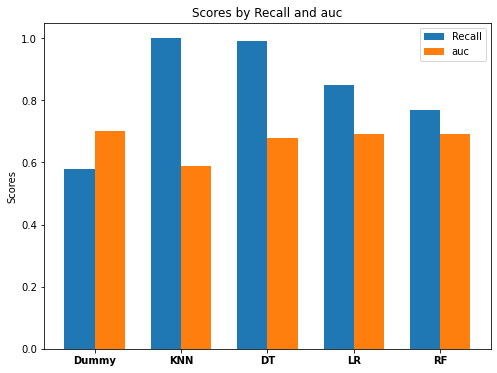

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = df_metrics['model'].tolist()
recall_val = df_metrics['recall'].tolist()
auc_val = df_metrics['auc'].tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
rects1 = ax.bar(x - width/2, recall_val, width, label='Recall')
rects2 = ax.bar(x + width/2, auc_val, width, label='auc')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Recall and auc')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(weight = 'bold')
ax.legend()

plt.show()

***
We can easily see that KNN and the DecisionTree are not suitable in their current form, as they both have extremely high recall, but the auc is low in comparison to their recall.
A more balanced outcome can be found for the LogisticRegression and the RandomForest.
The LogisticRegression is actually better than the RandomForest, which is unexpected.
While both have a higher recall than the baseline, their auc still is quite poor.
It is clear that all of the models need to be improved.
***